### Imports

In [1]:
#data manipulations
import pandas as pd
import numpy as np

#visualization
import matplotlib.pyplot as plt
import seaborn as sns
import os
 
#stats
from scipy import stats

#my own files with my own functions
import acquire
# import prepare
# import explore

from scipy.stats import chi2_contingency


# train test split function and models
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression


In [ ]:
# PREPARE FUNCTIONS

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt



def prep_telco(df):
    '''Takes in the telco churn dataframe as an argument and returns the dataframe
    with unnecessary columns dropped and empty values in the [total_charges] column
    changed from a blank space to a zero. The new column total_add_on_count is created by 
    summing each customers number of add-ons while also accounting for customers with no internet.
    It creates a new column tenure years which is the age of customer account starting with 0 for 
    customers with accounts up to 12 months old. 
    '''
    # A variable that represents all possible add-on services a customer can have
    columns_to_sum = ['online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']

    # New column that looks through each row and when a "yes" is found in columns_to_sum, it adds a 1
    df['total_add_on_count'] = df[columns_to_sum].apply(lambda row: sum(1 if value == 'Yes' else 0 if value == 'No' else 9 for value in row), axis=1)
    
    # change the number 54 to no internet service
    df['total_add_on_count'].replace({54:'No internet service'}, inplace=True)

    # Remove the add-on service columns
    df.drop(columns=df[columns_to_sum], inplace=True)

    # bin edges for each year 
    bins = [0, 12, 24, 36, 48, 60, 72, 84] 

    # Create labels for the bins (representing years)
    labels = ['0', '1', '2', '3', '4', '5', '6']

    # Bin the 'tenure' column
    df['tenure_years'] = pd.cut(df['tenure'], bins=bins, labels=labels, right=False)

    # drop SQL joiner columns, phone service is replaced with phone service type, and tenure is replaced with tenure years
    df.drop(columns=['payment_type_id', 'internet_service_type_id', 'contract_type_id', 'phone_service', 'tenure'], inplace=True)
    
    # Handle blank spaces in total_charges
    df.total_charges = df.total_charges.str.replace(' ', '0.0')
    
    # Replace empty spaces to match the rest of the columns
    df.internet_service_type.fillna('No internet service', inplace = True)
    
    #change the type of total_charges to float
    df['total_charges'] = df['total_charges'].astype(float)
    
    # Repalce bool to string for easier reading
    df['senior_citizen'].replace({0:'No', 1: 'Yes'}, inplace=True)
    
    # Rename column to combine multiple lines and phone service into one column
    df.rename(columns={'multiple_lines': 'phone_service_type'}, inplace=True)
    
    # 
    df['phone_service_type'].replace({'Yes':'Multiple lines', 'No': 'Single line'}, inplace=True)
    
    # change index to customer ID since it is a unique identifier and relevant to stakeholders
    df = df.set_index('customer_id')

    return df







def split_data(df, target):
    """
    This function takes in any DataFrame and a target variable as an argument 
    and returns train, validate, and test dataframes stratifying on the target variable.
    It returns three DataFrames with a printout of their proportion to the original DataFrame.
    """
    train, validate_test = train_test_split(
        df, train_size=0.6, random_state=123, stratify=df[target]
    )
    validate, test = train_test_split(
        validate_test, train_size=0.5, random_state=123, stratify=validate_test[target]
    )
    print(f"train: {len(train)} ({round(len(train)/len(df), 2)*100}% of {len(df)})")
    print(
        f"validate: {len(validate)} ({round(len(validate)/len(df), 2)*100}% of {len(df)})"
    )
    print(f"test: {len(test)} ({round(len(test)/len(df), 2)*100}% of {len(df)})")

    return train, validate, test









def preprocess_telco(train_df, val_df, test_df):
    '''
    This function takes three DataFrames as an argument 
    and returns train, validate, and test dataframes ready for machine learning.
    It returns DataFrames with all string values changed to represent a binary equivalent.
    '''
    # variable for all of our columns that should be in a numerical type
    columns_to_convert = ['gender', 'senior_citizen', 'partner', 'dependents', 'paperless_billing', 'churn', 'tenure_years', 'total_add_on_count']

    # variable for our features with string values
    encoding_vars = ['contract_type', 'internet_service_type', 'payment_type', 'phone_service_type']

    # Initialize a lsit of dataframes
    encoded_dfs = []
    for df in [train_df, val_df, test_df]:
        # Replace certain string values with numerical values
        df.replace({"No": 0, "Yes": 1, "Male": 1, "Female": 0, "No internet service": 0}, inplace=True)

        # get dummy variables for columns with string values
        df_encoded_cats = pd.get_dummies(df[encoding_vars], drop_first=True).astype(int)
        
        # concatenate dummy columns to dataframe and drop the orginal columns 
        df = pd.concat([df, df_encoded_cats], axis=1).drop(columns=encoding_vars)
        
        # Convert specified columns to integer type
        df[columns_to_convert] = df[columns_to_convert].astype(int)
        
        # add changes to all three dataframes
        encoded_dfs.append(df)

    return encoded_dfs








def predicted_probabilities(y_pred_proba, y_pred, title='Predicted Probabilities vs Predicted Class'):
    """
    Plot a scatter plot of predicted probabilities vs predicted class labels.

    Parameters:
    - y_pred_proba: Array-like, predicted probabilities for the positive class.
    - y_pred: Array-like, predicted class labels (0 or 1).
    - title: String, title of the plot.

    Returns:
    None
    """
    fig = plt.figure(figsize=[5, 3])
    ax = fig.add_subplot()

    # scatter plot where x is the probabilities and y is the class (0, 1)
    ax.scatter(y_pred_proba, y_pred, alpha=0.05)

    plt.xlabel('Predicted Probabilities')
    plt.ylabel('Predicted Class (0 or 1)')
    plt.title(title)
    plt.show()




In [ ]:
# EXPLORE FUNCTIONS



import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt








def visualize_churn_distribution(df):
    '''
    Trakes in a DataFrame and returns a pie plot visual of the 'churn' column.
    This represents the distribution of the target variable for the data set. 
    '''
    # Count the number of customers who have churned and those who haven't
    churn_counts = df['churn'].value_counts()

    # Plot a pie chart
    labels = ['Not Churned', 'Churned']
    colors = ['lightsteelblue', 'sandybrown']

    plt.pie(churn_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.title('Distribution of Churned vs Not Churned Customers')
    plt.show()






def analyze_tenure_years(df, column, target_column):
    '''
    Takes in a DataFrame the tenure years column, and the target column. 
    Returns: A printed contingency table, the visualization of the contingency table as a count plot, 
    and the results of the chi sqaured test of independence.
    
    '''
    # Create a contingency table
    contingency_table = pd.crosstab(df[column], df[target_column])
    
    # Plot a stacked bar chart (count plot)
    plt.figure(figsize=(6, 3))
    sns.countplot(x=column, hue=target_column, data=df, palette='pastel')
    plt.title(f' Bar Chart - {column} vs {target_column}')
    plt.show()

    # Perform a chi-squared test
    chi2, p, _, _ = chi2_contingency(contingency_table)
    
    # Display the contingency table
    print("Contingency Table:")
    print(contingency_table)
    
    # Display the chi-squared test results
    print("\nChi-squared test:")
    print(f"Chi2 Statistic: {chi2}")
    print(f"P-value: {p}")


    




def analyze_total_add_on_count(df, column, target_column):
    '''
    Function takes in a DataFrame, the total_add_on_count column, and the target variable.
    It generates a contingency table using pandas crosstab, orders the add-on values for plotting purposes, 
    creates a count plot of the contingency table, performs a chi squared test using chi2_contingency, displays the table and the results.
    '''
    # Create a contingency table
    contingency_table = pd.crosstab(df[column], df[target_column])
    
    # Order the values into something that makes sense for a plot
    order = ['0', '1', '2', '3', '4', '5', '6', 'No internet service']
    # Convert the column to categorical with the specified order
    df[column] = pd.Categorical(df[column], ordered=True)

    # Create the countplot
    contingency_table.plot.bar(stacked=False, color=['lightsteelblue', 'sandybrown'], figsize=(6, 3))
    plt.title(f'total_add_on_count vs. churn')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.show()

    # Perform a chi-squared test
    chi2, p, _, _ = chi2_contingency(contingency_table)
    
    # Display the contingency table
    print("Contingency Table:")
    print(contingency_table)
    
    # Display the chi-squared test results
    print("\nChi-squared test:")
    print(f"Chi2 Statistic: {chi2}")
    print(f"P-value: {p}")





    


def analyze_payment_type(df, column, target_column):
    '''
    Functions takes in a dataframe, the payment type column, and the target column. 
    Returns: First generates a contingency table using pandas crosstab, a count plot of the payment type vs. target variable, 
    it performs a chi squared test of independence, and prints the results of the test as well as the contingency table.
    '''
    # Create a contingency table
    contingency_table = pd.crosstab(df[column], df[target_column])

    # Plot a stacked bar chart (count plot)
    plt.figure(figsize=(10, 3))
    sns.countplot(x=column, hue=target_column, data=df, palette='pastel')
    plt.title(f' Bar Chart - {column} vs {target_column}')
    plt.show()

    # Perform a chi-squared test
    chi2, p, _, _ = chi2_contingency(contingency_table)
    
    # Display the contingency table
    print("Contingency Table:")
    print(contingency_table)
    
    # Display the chi-squared test results
    print("\nChi-squared test:")
    print(f"Chi2 Statistic: {chi2}")
    print(f"P-value: {p}")





## Acquire 
 - Get data from Codeup DS Database Server 
 - Data contains 7043 rows and 24 columns
 - Each row represents a customer
 - Each columns represents a feature of a customer





## Data Dictionary 

 
 
| Column Name                  | Description                                          |
|-----------------------------|------------------------------------------------------|
| customer_id                  | Unique identifier for each customer.                |
| gender                       | Gender of the customer.                             |
| senior_citizen               | Indicates if the customer is a senior citizen (1) or not (0). |
| partner                      | Indicates if the customer has a partner (Yes/No).    |
| dependents                   | Indicates if the customer has dependents (Yes/No).   |
| tenure                       | Number of months the customer has been with the company. |
| phone_service                | Indicates if the customer has phone service (Yes/No). |
| multiple_lines               | Indicates if the customer has multiple phone lines (Yes/No). |
| internet_service_type_id    | Identifies the type of internet service the customer has. |
| online_security              | Indicates if the customer has online security service (Yes/No). |
| online_backup                | Indicates if the customer has online backup service (Yes/No). |
| device_protection            | Indicates if the customer has device protection service (Yes/No). |
| tech_support                 | Indicates if the customer has tech support service (Yes/No). |
| streaming_tv                 | Indicates if the customer has streaming TV service (Yes/No). |
| streaming_movies             | Indicates if the customer has streaming movie service (Yes/No). |
| contract_type_id            | Identifies the type of contract the customer has.    |
| paperless_billing           | Indicates if the customer has paperless billing (Yes/No). |
| payment_type_id             | Identifies the type of payment method the customer uses. |
| monthly_charges             | The amount charged to the customer per month.       |
| total_charges               | The total amount charged to the customer.           |
| churn                       | Indicates if the customer has churned (Yes/No).     |
| internet_service_type       | Description of the internet service type.           |
| payment_type                | Description of the payment method.                  |
| contract_type               | Description of the contract type.                   |


## Prepare 
 * Create a new column tenure_years to represent how old a customer account is in years.
 * Drop tenure since we have tenure_years.
 * Rename column multiple_lines to phone_service_type to match other columns.
 
 - Replace phone_service_type value yes to multiple lines and no to single lines.
 - Drop phone_service since we now have phone_service_type with yes,no, and No phone service. (this format matches other columns).
 
 + Create a new column total_add_on_count to represent how many add-on services each customer has.
 + Add-on services include online_security, online_backup, device_protection, tech_support, streaming_tv, and streaming_movies. 
 + New column sums a 1 when a yes is in the add-on column.
 + New column is 0-6 for customers with internet and includes the value No internet service for people who are not eligible for add-on services.
 + Drop add-on services columns.
 
 - Remove SQL joiner columns payment_type_id, internet_service_type_id, and payment_type_id.
 - Checked for null values in the data.
 - Fill nulls in internet service type with No internet service to match columns.
 - Fill blank space in total_charges with zero for new customers without a bill.
 - Change data type of total_charges to float.
 - For senior citizen, replace boolean values with yes or no for easy reading.
 - Change index to be customer ID.
 - Split data into train, validate, and test.


In [2]:
# acquire and prepare data
df = prepare.prep_telco(acquire.get_telco_data())

In [3]:
# split data into train, validate, and test
train, validate, test = prepare.split_data(df, 'churn')

train: 4225 (60.0% of 7043)
validate: 1409 (20.0% of 7043)
test: 1409 (20.0% of 7043)


### First Looks

In [4]:
# look at first 5 rows of data
train.head()

,gender,senior_citizen,partner,dependents,phone_service_type,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type,total_add_on_count,tenure_years
customer_id,,,,,,,,,,,,,,
4083-BFNYK,Female,Yes,Yes,No,Multiple lines,No,95.00,3591.25,No,One year,Fiber optic,Credit card (automatic),3,3
5804-LEPIM,Female,Yes,No,No,Single line,Yes,70.35,139.05,Yes,Month-to-month,Fiber optic,Electronic check,0,0
4895-TMWIR,Male,Yes,Yes,No,Single line,No,19.95,214.75,Yes,Month-to-month,No internet service,Mailed check,No internet service,0
1342-JPNKI,Male,No,No,No,Multiple lines,Yes,86.05,834.10,Yes,Month-to-month,Fiber optic,Bank transfer (automatic),1,0
3397-AVTKU,Male,No,No,No,Single line,Yes,60.00,2548.55,No,Two year,DSL,Electronic check,2,3


### Data summary

In [5]:
# descriptive statistics 
train.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
gender,4225,2,Male,2116,NaN,NaN,NaN,NaN,NaN,NaN,NaN
senior_citizen,4225,2,No,3531,NaN,NaN,NaN,NaN,NaN,NaN,NaN
partner,4225,2,No,2160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dependents,4225,2,No,2961,NaN,NaN,NaN,NaN,NaN,NaN,NaN
phone_service_type,4225,3,Single line,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN
paperless_billing,4225,2,Yes,2507,NaN,NaN,NaN,NaN,NaN,NaN,NaN
monthly_charges,4225.0,NaN,NaN,NaN,65.138947,30.336884,18.25,35.4,70.55,90.4,118.75
total_charges,4225.0,NaN,NaN,NaN,2305.884888,2282.408946,0.0,408.25,1389.35,3886.45,8672.45
churn,4225,2,No,3104,NaN,NaN,NaN,NaN,NaN,NaN,NaN
contract_type,4225,3,Month-to-month,2335,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Explore

### How often do customers churn?

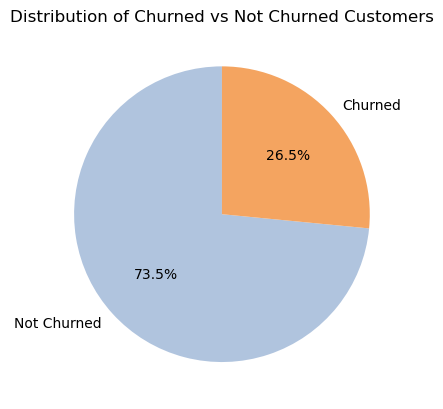

In [6]:
# distribution of our target variable
explore.visualize_churn_distribution(train)

> Just over 1/4 of customers churn

### Are new customers more likely to churn?

 $H_0$: There is no relationship between tenure and whether or not someone has churned

 $H_a$: There is a relationship between tenure and whether or not someone has churned
 
 aplha = 0.05

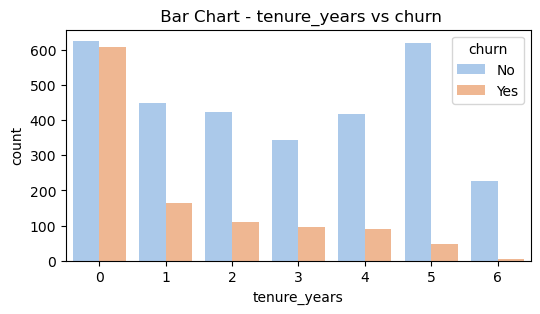

Contingency Table:
churn          No  Yes
tenure_years          
0             626  609
1             448  164
2             422  110
3             343   95
4             417   89
5             620   49
6             228    5

Chi-squared test:
Chi2 Statistic: 561.8805072854334
P-value: 3.8769280255400623e-118


In [7]:
# Plot to visualize and draw conclusions from the assosociation. 
explore.analyze_tenure_years(train, 'tenure_years', 'churn')

>  There is a significant assocaiation between tenure and customer churn. 
- More customers churned by the first year.

### Is there a relationship between the number of add-ons  and whether or not a customer has churned?

$H_0$: There is not a significant difference between the number of add-ons and churn.

$H_a$: There is a significant difference between the number of add-ons and churn.
 
 aplha = 0.05

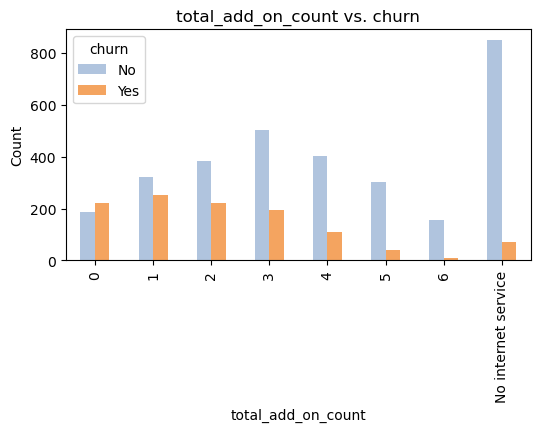

Contingency Table:
churn                 No  Yes
total_add_on_count           
0                    188  221
1                    320  251
2                    382  220
3                    504  196
4                    403  111
5                    303   41
6                    156   11
No internet service  848   70

Chi-squared test:
Chi2 Statistic: 525.9314282895757
P-value: 2.1268933468180813e-109


In [9]:
explore.analyze_total_add_on_count(train, 'total_add_on_count', 'churn')

> Reject the null hypothesis: There is a significant difference betwen the number of add-on services and churn .

- customers with fewer add-ons churn more.
             

###  Do payment methods affect churn?

$H_0$: There is not a significant difference between the customer payment method and churn.

$H_a$: There is a significant difference between the customer payment method and churn.
 
 aplha = 0.05

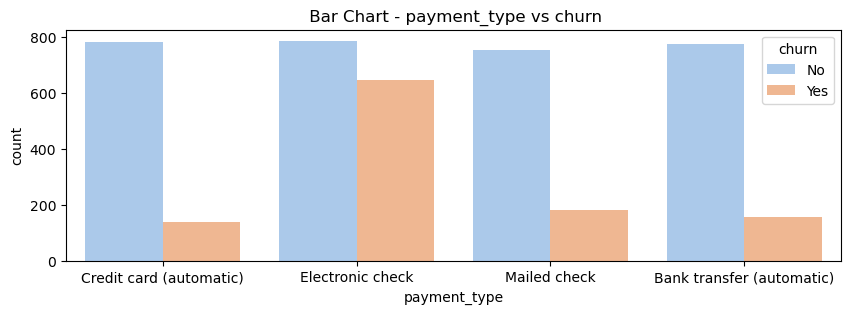

Contingency Table:
churn                       No  Yes
payment_type                       
Bank transfer (automatic)  778  157
Credit card (automatic)    783  138
Electronic check           788  646
Mailed check               755  180

Chi-squared test:
Chi2 Statistic: 386.1839951483273
P-value: 2.1760476161221612e-83


In [10]:
explore.analyze_payment_type(train, 'payment_type', 'churn')

> Reject the null hypothesis: There is a significant difference the payment type and churn .

- customers with electronic check payment method have higher numbers of churn.
           

### Exploration Summary

 - Over 1/4 of customers churn
 - The type of contract a customer has is a driver of churn
 - Tenure is a driver of churn.
 - The number of add-ons are a driver of churn
 - Payment methods are drivers of churn
 

# Modeling

### Preprocess 

 - Encode values for contract_type, internet_service_type, payment_type, phone_service_type. 
 - Remove columns contract_type, internet_service_type, payment_type, phone_service_type.
 - Replace yes with 1 no with 0 and no internet with 0
 - Convert all columns to a numerical data type.
 

In [11]:
# Encode data for machine learning. 
train, validate, test = prepare.preprocess_telco(train, validate, test)

### Baseline

 - Accuracy will be used as the evaluation metric
 - Accuracy = (TP + TN)/ (TP + TN + FP +FN)

In [12]:
# baseline is the target outcome mode
baseline_prediction=train.churn.mode()
baseline_accuracy = (train.churn == 0).mean()
print(f'Baseline Prediction: {baseline_prediction}')
print(f'Baseline Accuracy: {baseline_accuracy}')

Baseline Prediction: 0    0
Name: churn, dtype: int64
Baseline Accuracy: 0.7346745562130178


 > non-churn customers makeup 73% of the data

### Separate Dataframes into features and target
 - Model will train on train dataframe features and train dataframe target.
 - Model will compare the difference between predicted and acutal target outcomes. 

In [13]:
# create two variables from train, one with only features and one for target. 
X_train = train.drop(columns=['churn'])
y_train = train.churn

# create two variables from validate, one with only features and one for target. 
X_validate = validate.drop(columns=['churn'])
y_validate = validate.churn

# create two variables from test, one with only features and one for target. 
X_test = test.drop(columns=['churn'])
y_test = test.churn

 Top Three models
 * Models with hyperparameters have been fit with train data and tuned with valiadate data.
 * Decsion Tree and Random Forest are pruned and tuned for best performance.

### Decision Tree

In [14]:
# create classifier object
clf = DecisionTreeClassifier(max_depth=7, min_samples_leaf=4, random_state=123)
#fit model on training data
clf = clf.fit(X_train, y_train)
# print result
print(f"Accuracy of Decision Tree on train data is {clf.score(X_train, y_train)}")
print(f"Accuracy of Decision Tree on validate data is {clf.score(X_validate, y_validate)}")

Accuracy of Decision Tree on train data is 0.8196449704142011
Accuracy of Decision Tree on validate data is 0.7913413768630234


> max depth of 7 with 4 min smaple leafs provides the best accuracy score for validate data which is .79

### Random Forest

In [15]:
# create classifier object
rf = RandomForestClassifier(max_depth=6, min_samples_leaf= 5,  random_state=123)
#fit model on training data
rf = rf.fit(X_train, y_train)
# print result
print(f"Accuracy of Random Forest on train data is {rf.score(X_train, y_train)}")
print(f"Accuracy of Random Forest on validate data is {rf.score(X_validate, y_validate)}")

Accuracy of Random Forest on train data is 0.8049704142011834
Accuracy of Random Forest on validate data is 0.8034066713981547


> max depth of 6 with 5 min sample leafs provides the best accuracy score for validate data which is .80

### Logistic Regression

In [16]:
# create classifier object
logit = LogisticRegression(solver='liblinear')
#fit model on training data
logit= logit.fit(X_train, y_train)
# print result
print(f"Accuracy of Logistic Regression on train data is {logit.score(X_train, y_train)}")
print(f"Accuracy of Logistic Regression  on validate data is {logit.score(X_validate, y_validate)}")

Accuracy of Logistic Regression on train data is 0.7936094674556213
Accuracy of Logistic Regression  on validate data is 0.8055358410220014


> Logistic Regression performed better on validate wirh 80%. Train and validate accuracy are above baseline.

# Comparing Models

 - All models performed better than baseline on train and validate. 
 - Decision Tree and Random Forest performed slightly worse when introduced to out of sample data, this is to be expected it lets us know our model generalizes well to new data.
 - I have chosen to move forward with the Logistic Regression model becuase this model acutally performed slightly better on validate data.

### Logistic Regression with Test Data


Use Logistic Regression with test since it is the best overall model. 

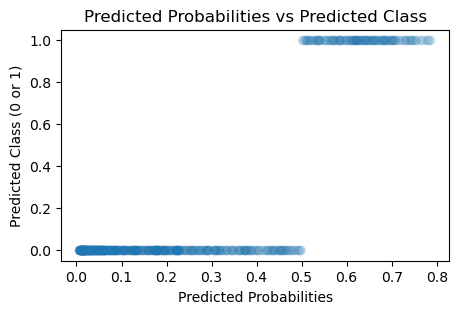

Accuracy of Logistic Regression on test is 0.8019872249822569


In [17]:
# probability and predictions for the test set
y_pred_proba = logit.predict_proba(X_test)[:, 1]
y_pred = logit.predict(X_test)
# show the 
prepare.predicted_probabilities(y_pred_proba, y_pred)
# Print accuracy score for X_test and y_test
print(f"Accuracy of Logistic Regression on test is {logit.score(X_test, y_test)}")

 - The final overall best model performs about as well as it did on our validate data. 
 - The model performes better than baselilne and train. 
 - This model performs well with unseen data consistently.

### Modeling Summary

 - Decsion Tree, Random Forest, and Logistics Regression models all performed better than baseline.
 - The Logistic Regression model performed better on validate and test, meaning it made accurate predictions on new data. This could mean our model is well generalized.
 -  A generalized model captures the complexities and underlying patterns in the data while not being overly complex to the point of overfitting. 

# Conclusions

### Exploration

 - Just over a quarter of customers have churned.
 - New customers are more likely to churn. Many new customers churn before or at 12 month of service. 
 - Shorter contracts are associated with churn, which corresponds with our understanding of the relationship between churn and tenure.
 - customers using internet with less add-ons are more likely to have churned. 

### Modeling

 - The top three models w where compared 
 - All performed well
 - Logistic Regressoin performed surprisingly well on new data
 

### Recommendations

 - Understand what customer needs are to ensure we are providing them with the best option. 
 - Shorter contracts and less services correlate with churn but that doesnt mean start making contracts longer and adding add-ons for every customer. 
 - Ensure customers are aware and offered services that meet their expectations and needs.
 - Recommend: An initative to increase customer loyalty.
 - Recommend: Offer customers a chance to signup for automatic payements with every customer interaction.

### Next Steps

 - Explore each add-on service instead of using the count. Find out which add-on services correlate with customer churn.

### Appendix

 Export Logistic Regression model final test predictions to csv file:

In [ ]:
'''  
# Make predictions on the test set
y_prob = logit.predict_proba(X_test)[:, 1]
y_pred = logit.predict(X_test)
# Create a DataFrame with the results
results_df = pd.DataFrame({'Probability_of_Churn': y_prob, 'Churn_Predicted': y_pred}, index=X_test.index)
# Print the DataFrame
print(results_df)
# read to csv
results_df.to_csv('churn_predictions_with_id.csv')
'''